In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/data.csv')

In [3]:
df = df.drop(['beats'], axis=1)

In [4]:
df.head()

,class_name,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues,103.359375,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues,95.703125,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues,151.999081,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues,184.570312,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues,161.499023,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [5]:
df['class_name'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

**Data Splitting for Training and Testing**

In [8]:
%matplotlib notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X = df.iloc[:,1:28]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

**Min-Max Normalization**

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

**Feature importance using Random Forest**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

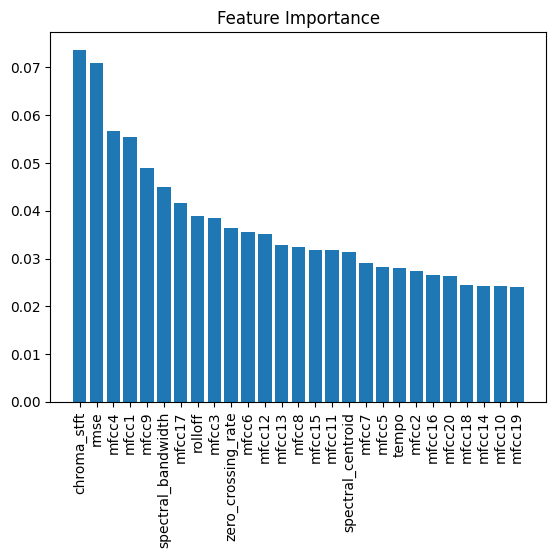

In [21]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

**Feature importance using Decision Tree**


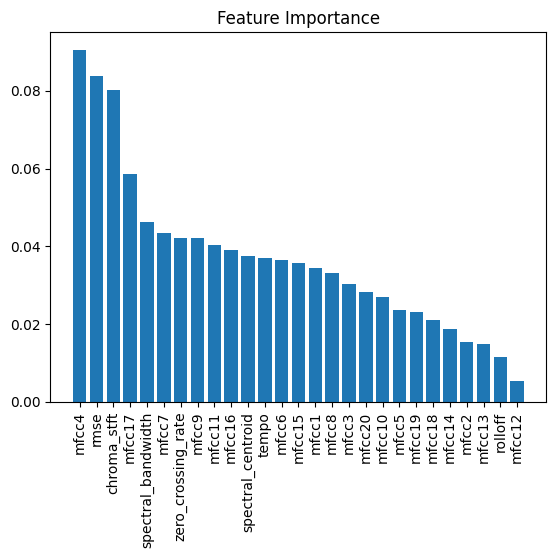

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

**Accuracy using KNN(K-Nearest Neighbors)**

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.624

**Accuracy using SVM(Support Vector Machine)**

In [24]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C=10).fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.732

**Prediction the Genre of the song**

In [13]:
pip install mutagen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 4.6 MB/s eta 0:00:00


In [17]:
import mutagen
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define and compile a Keras Sequential model for genre prediction
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=193))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load mp3 file
audio_file = mutagen.File('/content/numb.mp3')
audio_data = audio_file.info.sample_rate, audio_file.info.channels, audio_file.info.length

# Load audio data using librosa
y, sr = librosa.load('/content/numb.mp3')

# Extract audio features
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)  # extract 12 MFCCs instead of the default 20

# Concatenate audio features into a single feature vector
features = np.concatenate((chroma_stft, spec_cent, spec_bw, rolloff, zcr, mfcc), axis=0)

# Compute the number of rows of zeros to add to the feature vector
num_rows = 193 - (features.shape[0] % 193)

# Pad the feature vector with zeros to make its size divisible by 193
padding = np.zeros((num_rows, features.shape[1]))
features = np.concatenate((features, padding), axis=0)

# Add a new axis to the feature vector to match the expected input shape of the model
features = features.T.reshape(-1, 193)

# Predict genre using pre-trained model
predicted_genre = model.predict(features)

# Map predicted genre label back to genre name
lookup_genre_name = {0: "pop", 1: "rock", 2: "country", 3: "disco", 4: "hiphop", 5: "jazz", 6: "metal"
, 8: "reggae", 9:"blues", 10:"classical"}
predicted_genre_label = (predicted_genre >= 0.5).astype(int)
predicted_genre_name = lookup_genre_name[predicted_genre_label[0][0]]

# Print predicted genre
print(predicted_genre_name)

253/253 [==============================] - 1s 2ms/step
rock


In [20]:
import mutagen
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define and compile a Keras Sequential model for genre prediction
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=193))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load mp3 file
audio_file = mutagen.File('/content/flowers.mp3')
audio_data = audio_file.info.sample_rate, audio_file.info.channels, audio_file.info.length

# Load audio data using librosa
y, sr = librosa.load('/content/flowers.mp3')

# Extract audio features
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)  # extract 12 MFCCs instead of the default 20

# Concatenate audio features into a single feature vector
features = np.concatenate((chroma_stft, spec_cent, spec_bw, rolloff, zcr, mfcc), axis=0)

# Compute the number of rows of zeros to add to the feature vector
num_rows = 193 - (features.shape[0] % 193)

# Pad the feature vector with zeros to make its size divisible by 193
padding = np.zeros((num_rows, features.shape[1]))
features = np.concatenate((features, padding), axis=0)

# Add a new axis to the feature vector to match the expected input shape of the model
features = features.T.reshape(-1, 193)

# Predict genre using pre-trained model
predicted_genre = model.predict(features)

# Map predicted genre label back to genre name
lookup_genre_name = {0: "pop", 1: "rock", 2: "country", 3: "disco", 4: "hiphop", 5: "jazz", 6: "metal"
, 8: "reggae", 9:"blues", 10:"classical"}
predicted_genre_label = (predicted_genre >= 0.5).astype(int)
predicted_genre_name = lookup_genre_name[predicted_genre_label[0][0]]

# Print predicted genre
print(predicted_genre_name)

270/270 [==============================] - 1s 2ms/step
pop
